# Data Preparation, Feature Selection, and Model Training with Random Forest

This guide demonstrates how to preprocess data, perform feature selection, train a Random Forest model, and evaluate it using various metrics, including the ROC-AUC score.

## Step 1: Import Libraries and Load Data

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load the dataset

In [58]:
df = pd.read_csv("data.csv")
     
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [59]:
df.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')

# Step 2: Separate Numerical and Categorical Features

In [60]:
df_num = df[['id', 'person_age', 'person_income','person_emp_length','loan_amnt',
       'loan_int_rate', 'loan_percent_income','cb_person_cred_hist_length']]
df_cat = df[['id','person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file','loan_status']]

# Step 3: Handle Missing Values and Clip Outliers in Numerical Data

In [61]:
# Drop rows with any missing values in df_num
df_num_clean = df_num.dropna()
df_num.shape

(58645, 8)

In [62]:
# Calculate 5th and 95th percentiles
lower_bound = df_num_clean.quantile(0.05)
upper_bound = df_num_clean.quantile(0.95)

# Clip the outliers
df_num_clipped = df_num_clean.mask(df_num_clean < lower_bound, lower_bound, axis=1)
df_num_clipped = df_num_clipped.mask(df_num_clipped > upper_bound, upper_bound, axis=1)
df_num.shape


(58645, 8)

# Step 4: Encode Categorical Variables

In [63]:
from sklearn.preprocessing import LabelEncoder

# Copy df_cat to avoid changing the original
df_cat_encoded = df_cat.copy()

# Apply one-hot encoding for nominal columns
df_cat_encoded = pd.get_dummies(df_cat_encoded, columns=['person_home_ownership', 'loan_intent', 'cb_person_default_on_file'])

# Apply label encoding for ordinal column (assuming 'loan_grade' is ordinal)
label_encoder = LabelEncoder()
df_cat_encoded['loan_grade'] = label_encoder.fit_transform(df_cat_encoded['loan_grade'])


# Step 5: Combine Processed Numerical and Categorical Data

In [64]:
# Perform an inner join on 'id' to combine both datasets
df_final = pd.merge(df_num_clipped, df_cat_encoded, on='id', how='inner')


C:\Users\Dell\AppData\Local\Temp\ipykernel_15660\3672235880.py:2: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  df_final = pd.merge(df_num_clipped, df_cat_encoded, on='id', how='inner')


# Method - 1 : 
### Step 6: Feature Selection using SelectKBest with f_classif

> Train-Test Split for Selected Features

> Train the Random Forest Model

> Evaluate the Model

> Plot the ROC Curve

In [65]:
from sklearn.feature_selection import SelectKBest, f_classif

# Separate features and target variable
X = df_final.drop(columns=['loan_status'])  # Features
y = df_final['loan_status']  # Target variable

# Apply SelectKBest with f_classif
k_best = SelectKBest(score_func=f_classif, k=5)  # Adjust 'k' as needed
X_selected = k_best.fit_transform(X, y)

# Get selected feature names
selected_features = X.columns[k_best.get_support()]

selected_features


Index(['person_income', 'loan_int_rate', 'loan_percent_income', 'loan_grade',
       'person_home_ownership_RENT'],
      dtype='object')

In [66]:
X_selected_df = pd.DataFrame(X_selected, columns=selected_features)

In [67]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.3, random_state=42)


In [68]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(accuracy,precision,recall,f1,roc_auc)
print("ROC-AUC",round(roc_auc*100,2),"%")


0.9210559555387141 0.760858189429618 0.6470850022251892 0.6993746993746994 0.91351054859535
ROC-AUC 91.35 %


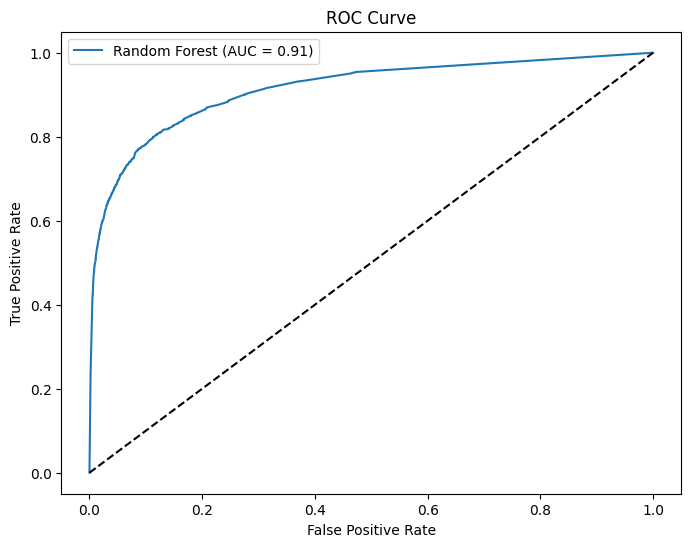

In [ ]:
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


# Method - 2 : 
### Step 7: Feature Selection using Correlation Matrix

> Train-Test Split for Selected Features

> Train the Random Forest Model

> Evaluate the Model

> Plot the ROC Curve

In [71]:
# Calculate the correlation matrix
correlation_matrix = df_final.corr()

# Get absolute correlation values with the target variable
correlation_with_target = correlation_matrix['loan_status'].abs().sort_values(ascending=False)


In [ ]:
# Define the number of top features to select
k = 5  

# Select the top-k features most correlated with the target variable
top_features = correlation_with_target.index[1:k+1] 
X_selected_df = df_final[top_features]


In [ ]:
from sklearn.model_selection import train_test_split

# Define the features and target variable
X = X_selected_df 
y = df_final['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [74]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC-AUC

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(accuracy,precision,recall,f1,roc_auc)
print("ROC-AUC",round(roc_auc*100,2),"%")


0.9223822154856638 0.7695974576271186 0.6466399643969737 0.7027811366384522 0.9118747143996679
ROC-AUC 91.19 %


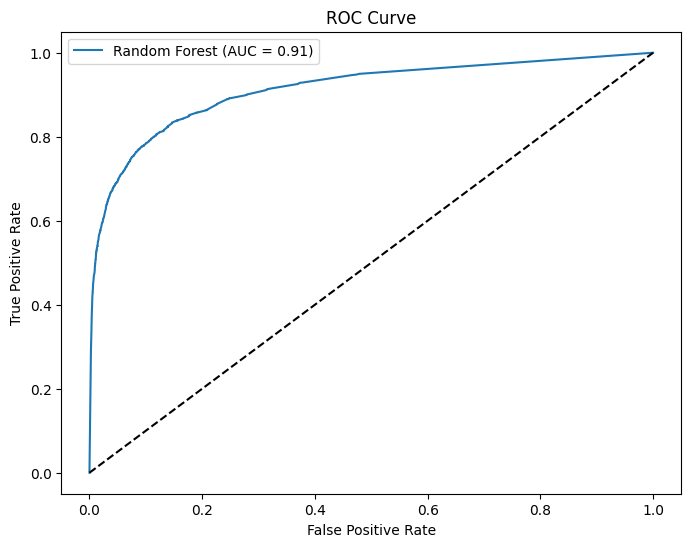

In [ ]:
import matplotlib.pyplot as plt

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()
